# ⚡ 4 Function Calling

⚠️ Note function-calling compatible GPT models: (https://platform.openai.com/docs/guides/function-calling).

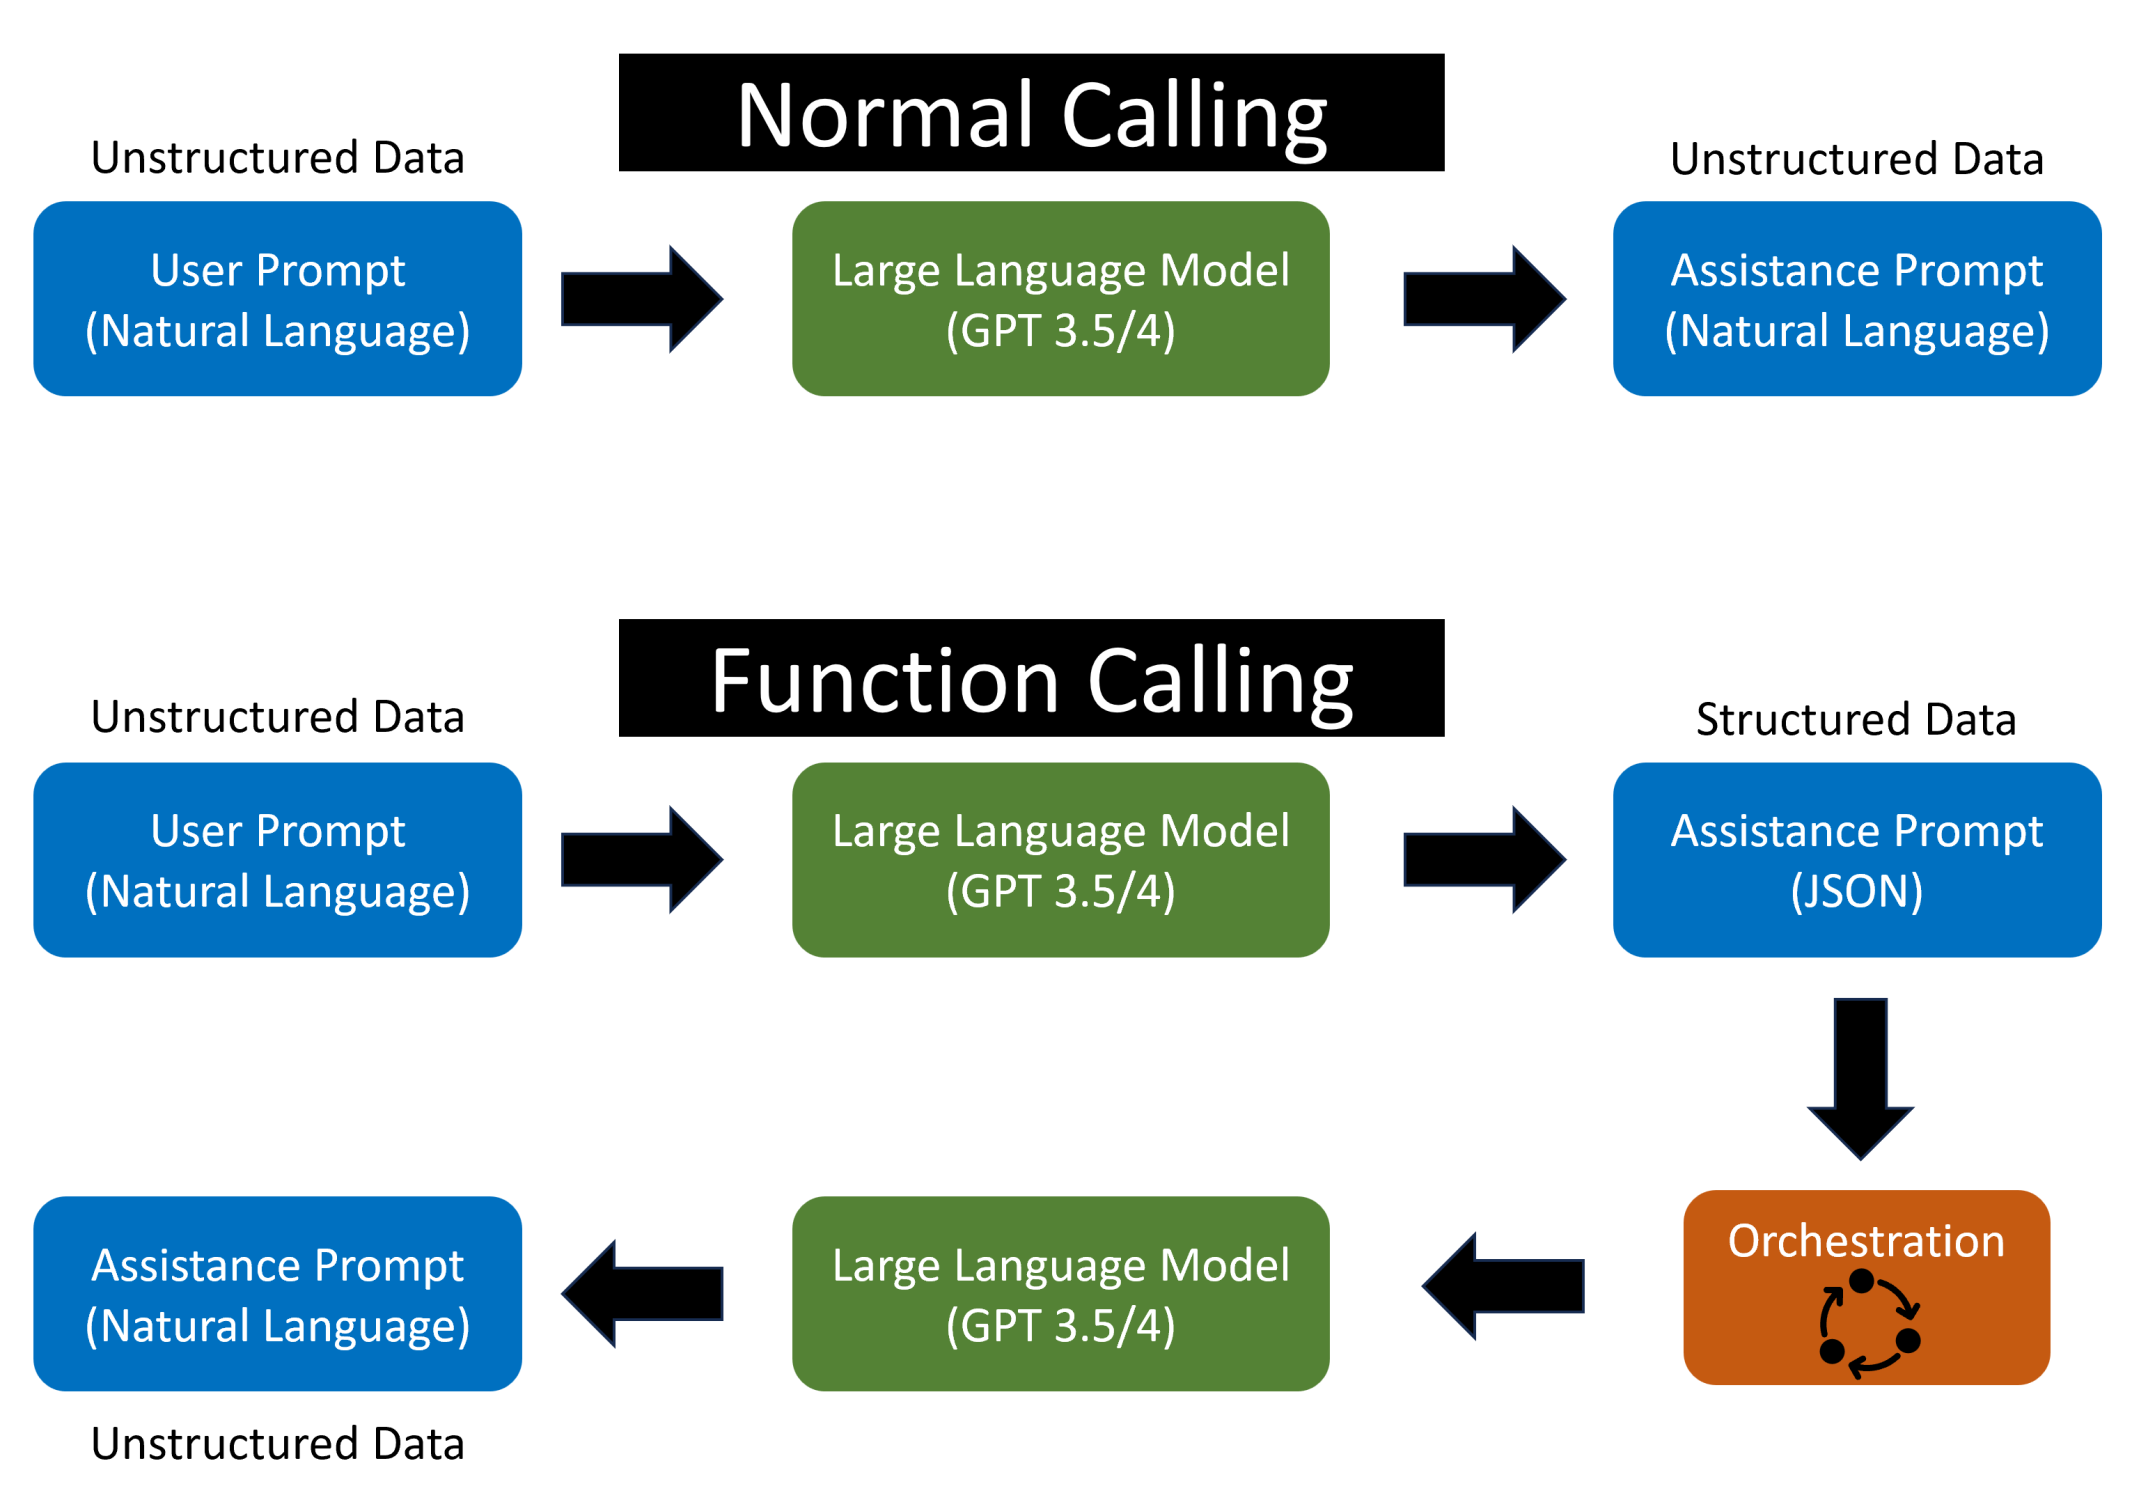

### Initialize the kernel

In [6]:
#r "nuget: Microsoft.SemanticKernel, 1.7.1"
#r "nuget: Microsoft.SemanticKernel.Plugins.Core, 1.7.1-alpha"

#!import Settings.cs

using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.Connectors.OpenAI;

var kernel = Settings.InitializeKernel();

Installed Packages Microsoft.SemanticKernel, 1.7.1 Microsoft.SemanticKernel.Plugins.Core, 1.7.1-alpha

### 🔌 Let's use a native function plugin.

In [7]:
using System.ComponentModel;
public class DateTimePlugin
{
    [KernelFunction]
    [Description("Retrieves the current date.")]
    public string GetCurrentDate() => DateTime.Now.ToShortDateString();
}

kernel.ImportPluginFromType<DateTimePlugin>("date");

### 📋 Let's prepare the execution settings and the kernel arguments.

In [8]:
var executionSettings = new OpenAIPromptExecutionSettings
{
    ToolCallBehavior = ToolCallBehavior.AutoInvokeKernelFunctions 
};

var kernelArguments = new KernelArguments(executionSettings)
{
    ["input"] = "Christmas"
};

var promptTemplate = "How many days until {{$input}}?";

var response = await kernel.InvokePromptAsync(promptTemplate, kernelArguments);

display(response.GetValue<string>())

Today's date is April 22, 2024. To find out how many days are left until Christmas, we need to calculate the days between today and December 25, 2024.

From April 22 to April 30, there are 8 days.
The entire months of May through November add up to 7 full months. Since 2024 is a leap year, February has 29 days, which means these 7 months sum up to: 31 (May) + 30 (June) + 31 (July) + 31 (August) + 30 (September) + 31 (October) + 30 (November) = 214 days.
Finally, from December 1 to December 25, there are 25 days.

Adding these together:
8 (rest of April) + 214 (full months) + 25 (December) = 247 days.

So there are 247 days until Christmas 2024.

### 🚰 This is the same example as above, but with streaming too

In [4]:
var executionSettings = new OpenAIPromptExecutionSettings
{
    ToolCallBehavior = ToolCallBehavior.AutoInvokeKernelFunctions 
};

var kernelArguments = new KernelArguments(executionSettings)
{
    ["input"] = "Christmas"
};

await foreach (var update in kernel.InvokePromptStreamingAsync("How many days until {{$input}}?", kernelArguments))
{
    Console.Write(update);
}

Today is April 22, 2024. Christmas will be on December 25, 2024. To calculate the number of days until Christmas:

From April 22 to April 30: 8 days
The entire months of May to November (31+30+30+31+31+30+31+30+31): 245 days
And finally, December 1 to December 25: 24 days

Adding these together: 8 + 245 + 24 = 277 days

There are 277 days until Christmas.

# 🧤 Manual

In [5]:
using System;
using System.Collections.Generic;
using System.Linq;
using System.Text.Json;
using System.Threading.Tasks;
using Azure.AI.OpenAI;
using Microsoft.Extensions.DependencyInjection;
using Microsoft.Extensions.Logging;
using Microsoft.SemanticKernel;
using Microsoft.SemanticKernel.ChatCompletion;
using Microsoft.SemanticKernel.Connectors.OpenAI;

var chat = kernel.GetRequiredService<IChatCompletionService>();
var chatHistory = new ChatHistory();

var executionSettings = new OpenAIPromptExecutionSettings
{
    ToolCallBehavior = ToolCallBehavior.EnableKernelFunctions 
};

chatHistory.AddUserMessage("How many days until Christmas?");
while (true)
{
    var result = (OpenAIChatMessageContent)await chat.GetChatMessageContentAsync(chatHistory, executionSettings, kernel);

    if (result.Content is not null)
    {
        Console.Write(result.Content);
    }

    List<ChatCompletionsFunctionToolCall> toolCalls = result.ToolCalls.OfType<ChatCompletionsFunctionToolCall>().ToList();
    if (toolCalls.Count == 0)
    {
        break;
    }

    chatHistory.Add(result);
    foreach (var toolCall in toolCalls)
    {
        string content = kernel.Plugins.TryGetFunctionAndArguments(toolCall, out KernelFunction? function, out KernelArguments arguments) ?
            JsonSerializer.Serialize((await function.InvokeAsync(kernel, arguments)).GetValue<object>()) :
            "Unable to find function. Please try again!";

        if (function != null)
        {
            Console.WriteLine($"  >> 🔌 {toolCall.Name.ToString()}: /{function.Name}");
        }

        Console.WriteLine($"       Result: {content}");

        chatHistory.Add(new ChatMessageContent(
            AuthorRole.Tool,
            content,
            metadata: new Dictionary<string, object>(1) { { OpenAIChatMessageContent.ToolIdProperty, toolCall.Id } }));
    }
}

  >> 🔌 date-GetCurrentDate: /GetCurrentDate
       Result: "4/22/2024"
Today is April 22, 2024. Christmas will be on December 25, 2024. To calculate the number of days until Christmas:

1. Find the remaining days in April: 30 (total days in April) - 22 (today's date) = 8 days
2. Add the total days in the full months between April and December: May (31 days), June (30 days), July (31 days), August (31 days), September (30 days), October (31 days), November (30 days) = 214 days
3. Add the days in December leading up to Christmas: 25 days

Now, add all these days together: 8 (April) + 214 (full months) + 25 (December) = 247 days

There are 247 days until Christmas 2024.